# Sprint 14, Sentiment Analysis, using tokenization and lemmatization, by Deborah Thomas

<h2>The Film Junky Union</h2>
<H3>A new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.</H3>

## Initialization

In [104]:
import math
import nltk
from nltk.corpus import stopwords

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import spacy

from lightgbm import LGBMClassifier

import torch
import transformers

import warnings

In [106]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [108]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [111]:
df_reviews = pd.read_csv('../datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [113]:
df_reviews.shape

(47331, 17)

In [115]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

- title_type may need to change to type category
- sp may need to change to boolean
- pos may need to change to boolean
- ds_part may need to change to type category
<br>
<br>
- average_rating has 2 missing values
- votes has 2 missing values

In [118]:
display(df_reviews)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [120]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


## Clean Dataset

### Look for NaN.

In [124]:
df_missing = df_reviews.isna().sum()
print(df_missing)

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [126]:
# Fill NaN values
df_reviews_filled = df_reviews.fillna(0)

# Check again for missing values
print(df_reviews_filled.isna().sum())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


4 rows have been removed.

### Check for Infinity values.

In [130]:
# Convert the DataFrame to numeric, forcing errors to NaN
numeric_df = df_reviews.select_dtypes(include=[np.number]).apply(pd.to_numeric, errors='coerce')

In [132]:
# Check for inf values in the DataFrame
inf_values_count = np.isinf(numeric_df).sum().sum()
print(f"Number of infinite values in df_reviews: {inf_values_count}")

Number of infinite values in df_reviews: 0


### Change datatypes

- title_type

In [136]:
df_reviews['title_type'].value_counts()

title_type
movie           36861
tvMovie          2892
video            2742
tvSeries         2246
short             887
tvMiniSeries      713
tvEpisode         635
tvSpecial         183
videoGame         154
tvShort            18
Name: count, dtype: int64

In [138]:
df_reviews['title_type'] = df_reviews['title_type'].astype('category')

- sp

In [141]:
df_reviews['sp'].value_counts()

sp
neg    23715
pos    23616
Name: count, dtype: int64

I will keep this as neg and pos.

- pos

In [145]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

In [147]:
df_reviews['pos'] = df_reviews['pos'].astype(bool)

- ds_part

In [150]:
df_reviews['ds_part'].value_counts()

ds_part
train    23796
test     23535
Name: count, dtype: int64

In [152]:
df_reviews['ds_part'] = df_reviews['ds_part'].astype('category')

In [154]:
df_reviews['ds_part'].value_counts()

ds_part
train    23796
test     23535
Name: count, dtype: int64

### Check for NaN.

In [157]:
df_missing = df_reviews.isna().sum()
print(df_missing)

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


### Fill NaN with mean value.

- average_rating

In [161]:
# Convert the columns to Float64 type
df_reviews['average_rating'] = df_reviews['average_rating'].astype(float)

# Calculate mean and fill NaN for 'average_rating'
mean_rating = df_reviews['average_rating'].mean()
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(mean_rating)

- votes

In [164]:
df_reviews['votes'] = df_reviews['votes'].astype(float)

# Calculate mean and fill NaN for 'votes'
mean_votes = df_reviews['votes'].mean()
df_reviews['votes'] = df_reviews['votes'].fillna(mean_votes)

In [166]:
# Select only numeric columns and convert DataFrame to float (or raise errors when conversion fails)
numeric_df = df_reviews.select_dtypes(include=[np.number]).astype(float)

# Check for infinite values
has_infinite = np.isinf(numeric_df.values).any()
print("Contains infinite values:", has_infinite)

Contains infinite values: False


In [168]:
# Select only numeric columns
numeric_df = df_reviews.select_dtypes(include=[np.number])

# Convert to a numpy array and handle type conversion
try:
    # Ensure all values are float, forcing conversion where possible
    has_infinite = np.isinf(numeric_df.astype(float).to_numpy()).any()
    print("Contains infinite values:", has_infinite)
except ValueError as e:
    print("Error in type conversion:", e)

Contains infinite values: False


In [170]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tconst           47331 non-null  object  
 1   title_type       47331 non-null  category
 2   primary_title    47331 non-null  object  
 3   original_title   47331 non-null  object  
 4   start_year       47331 non-null  int64   
 5   end_year         47331 non-null  object  
 6   runtime_minutes  47331 non-null  object  
 7   is_adult         47331 non-null  int64   
 8   genres           47331 non-null  object  
 9   average_rating   47331 non-null  float64 
 10  votes            47331 non-null  float64 
 11  review           47331 non-null  object  
 12  rating           47331 non-null  int64   
 13  sp               47331 non-null  object  
 14  pos              47331 non-null  bool    
 15  ds_part          47331 non-null  category
 16  idx              47331 non-null  int64  

## EDA

- Check for class imbalance

In [174]:
class_counts = df_reviews['pos'].value_counts()
print(class_counts)

pos
False    23715
True     23616
Name: count, dtype: int64


In [176]:
class_ratios = class_counts / len(df_reviews)
print(class_ratios)

pos
False    0.501046
True     0.498954
Name: count, dtype: float64


There is a good balance between False and True.

- <H3>Let's check the number of movies and reviews over years.</H3>

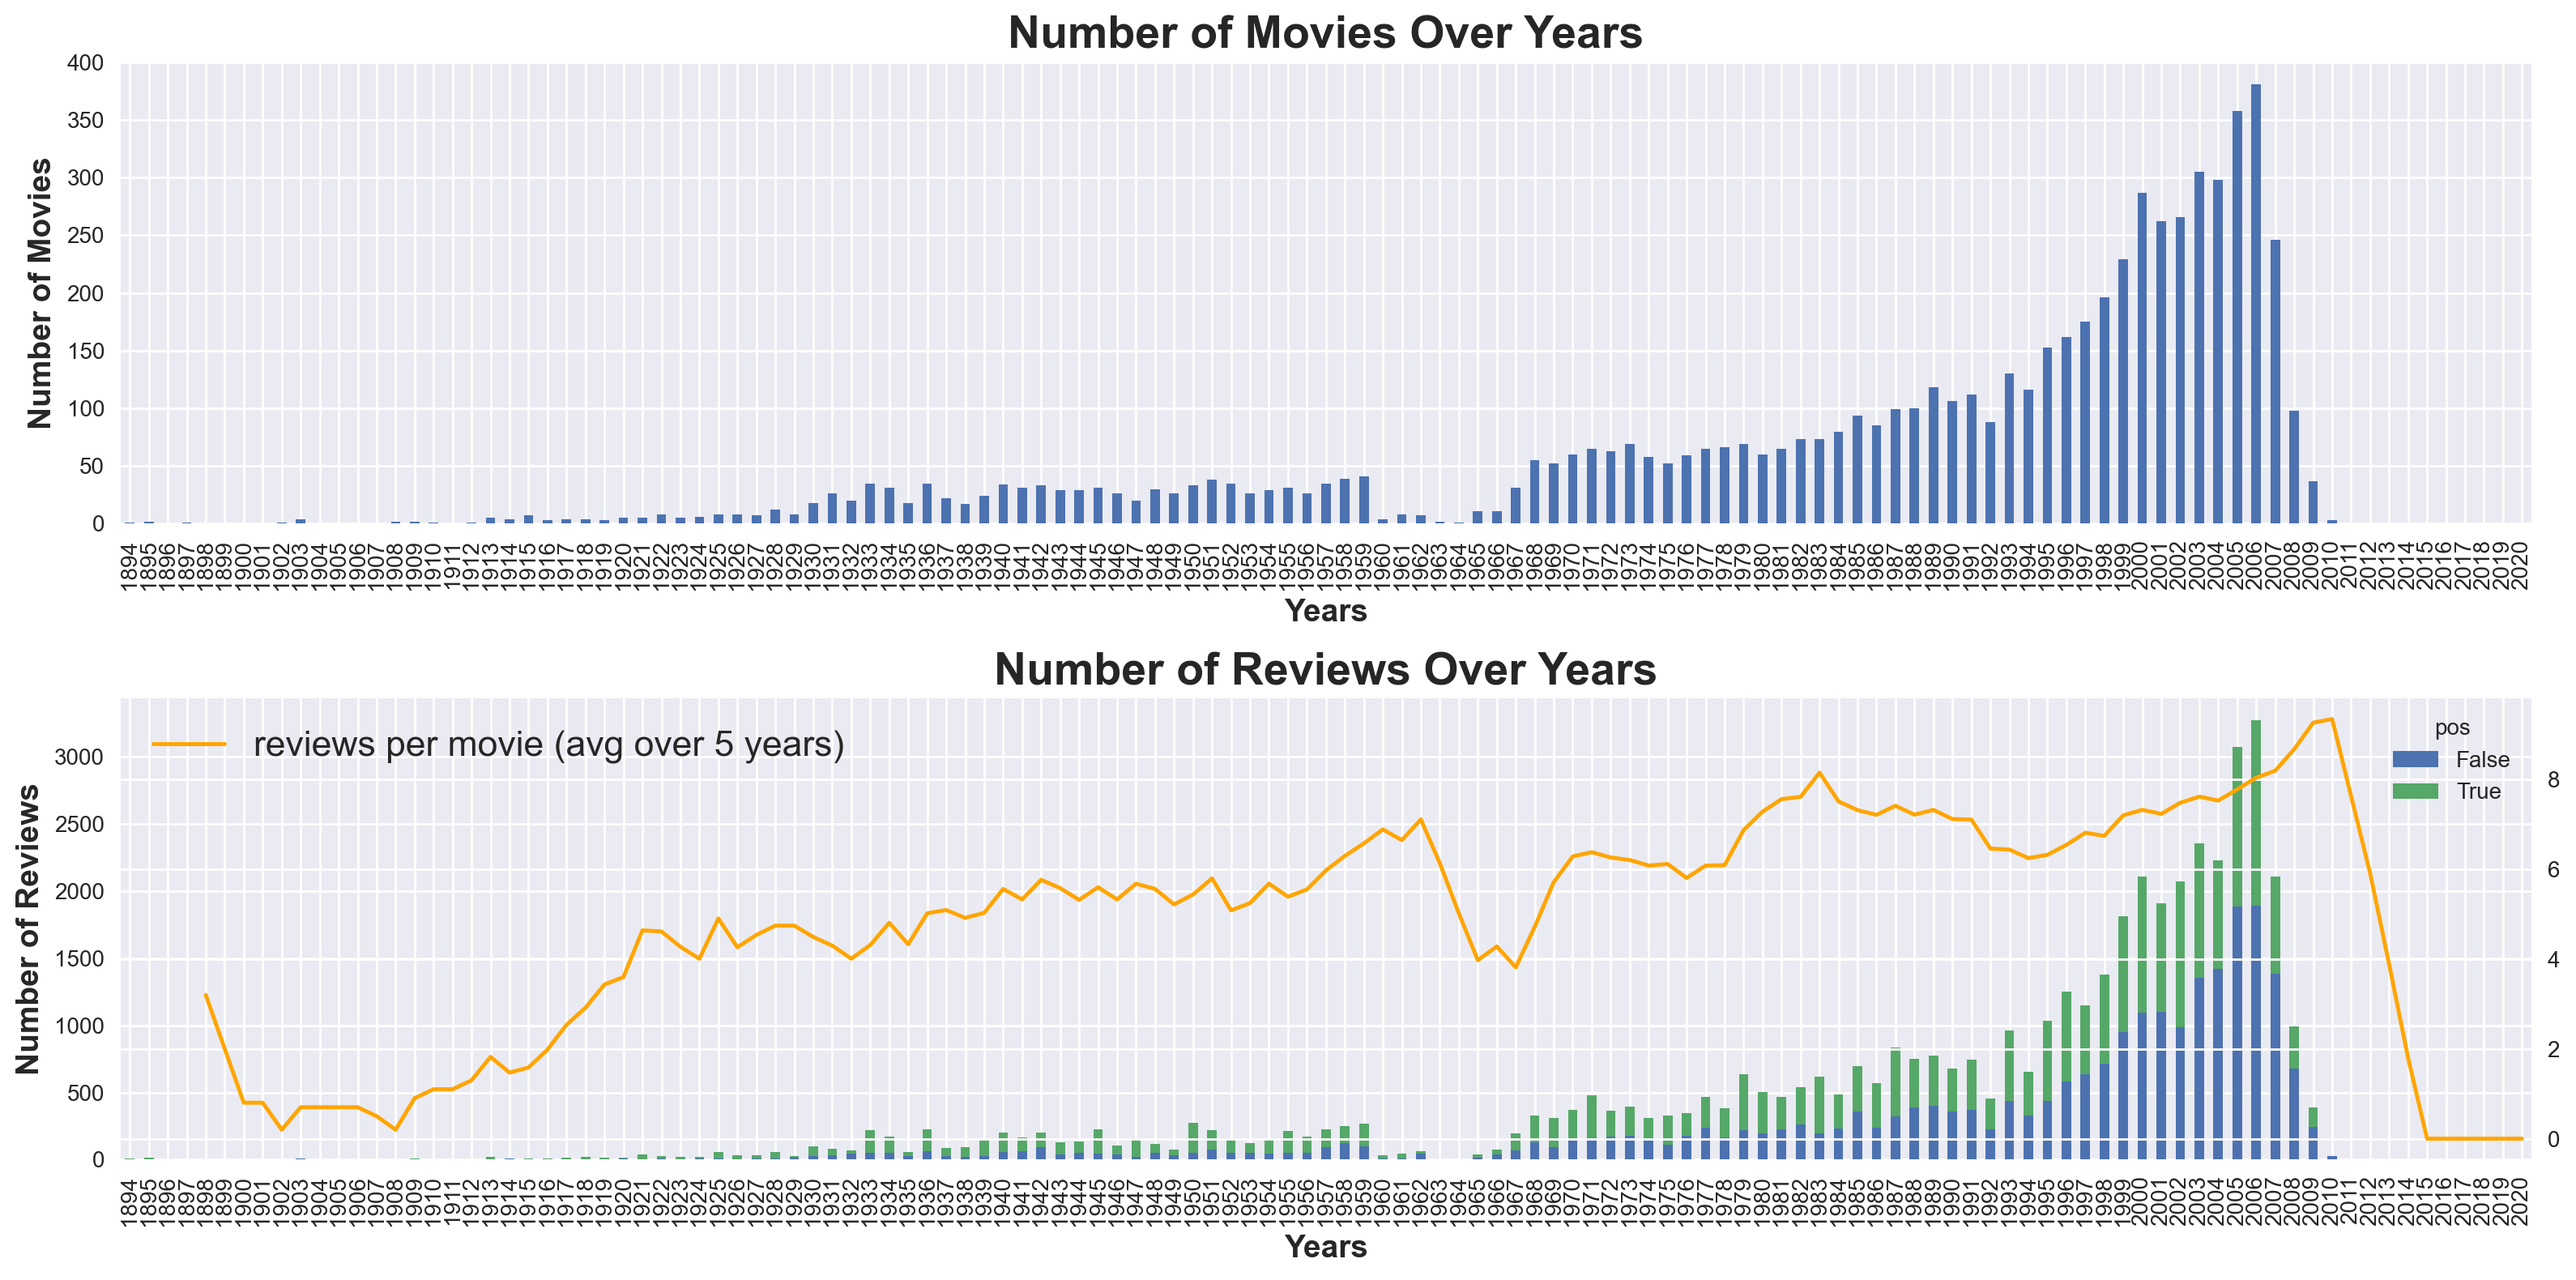

In [180]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# First subplot
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)

ax.set_title('Number of Movies Over Years', fontsize=20, fontweight='bold')
ax.set_xlabel('Years', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')

# Second subplot
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)

axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)
lines, labels = axt.get_legend_handles_labels()

axt.legend(lines, labels, loc='upper left', fontsize=16) 

ax.set_title('Number of Reviews Over Years', fontsize=20, fontweight='bold')  # Keep this for the second subplot
ax.set_xlabel('Years', fontsize=14, fontweight='bold')  # Make x-label bold
ax.set_ylabel('Number of Reviews', fontsize=14, fontweight='bold')

# Adjust layout to create more room at the bottom
plt.subplots_adjust(hspace=0.6)  # Increase the space between subplots
fig.tight_layout()

The amount of movies produced increases, over the years, til 2006, when then the amount of movies declines. There is an even balance betwen False and True.

- <H3>Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)</H3>

In [184]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

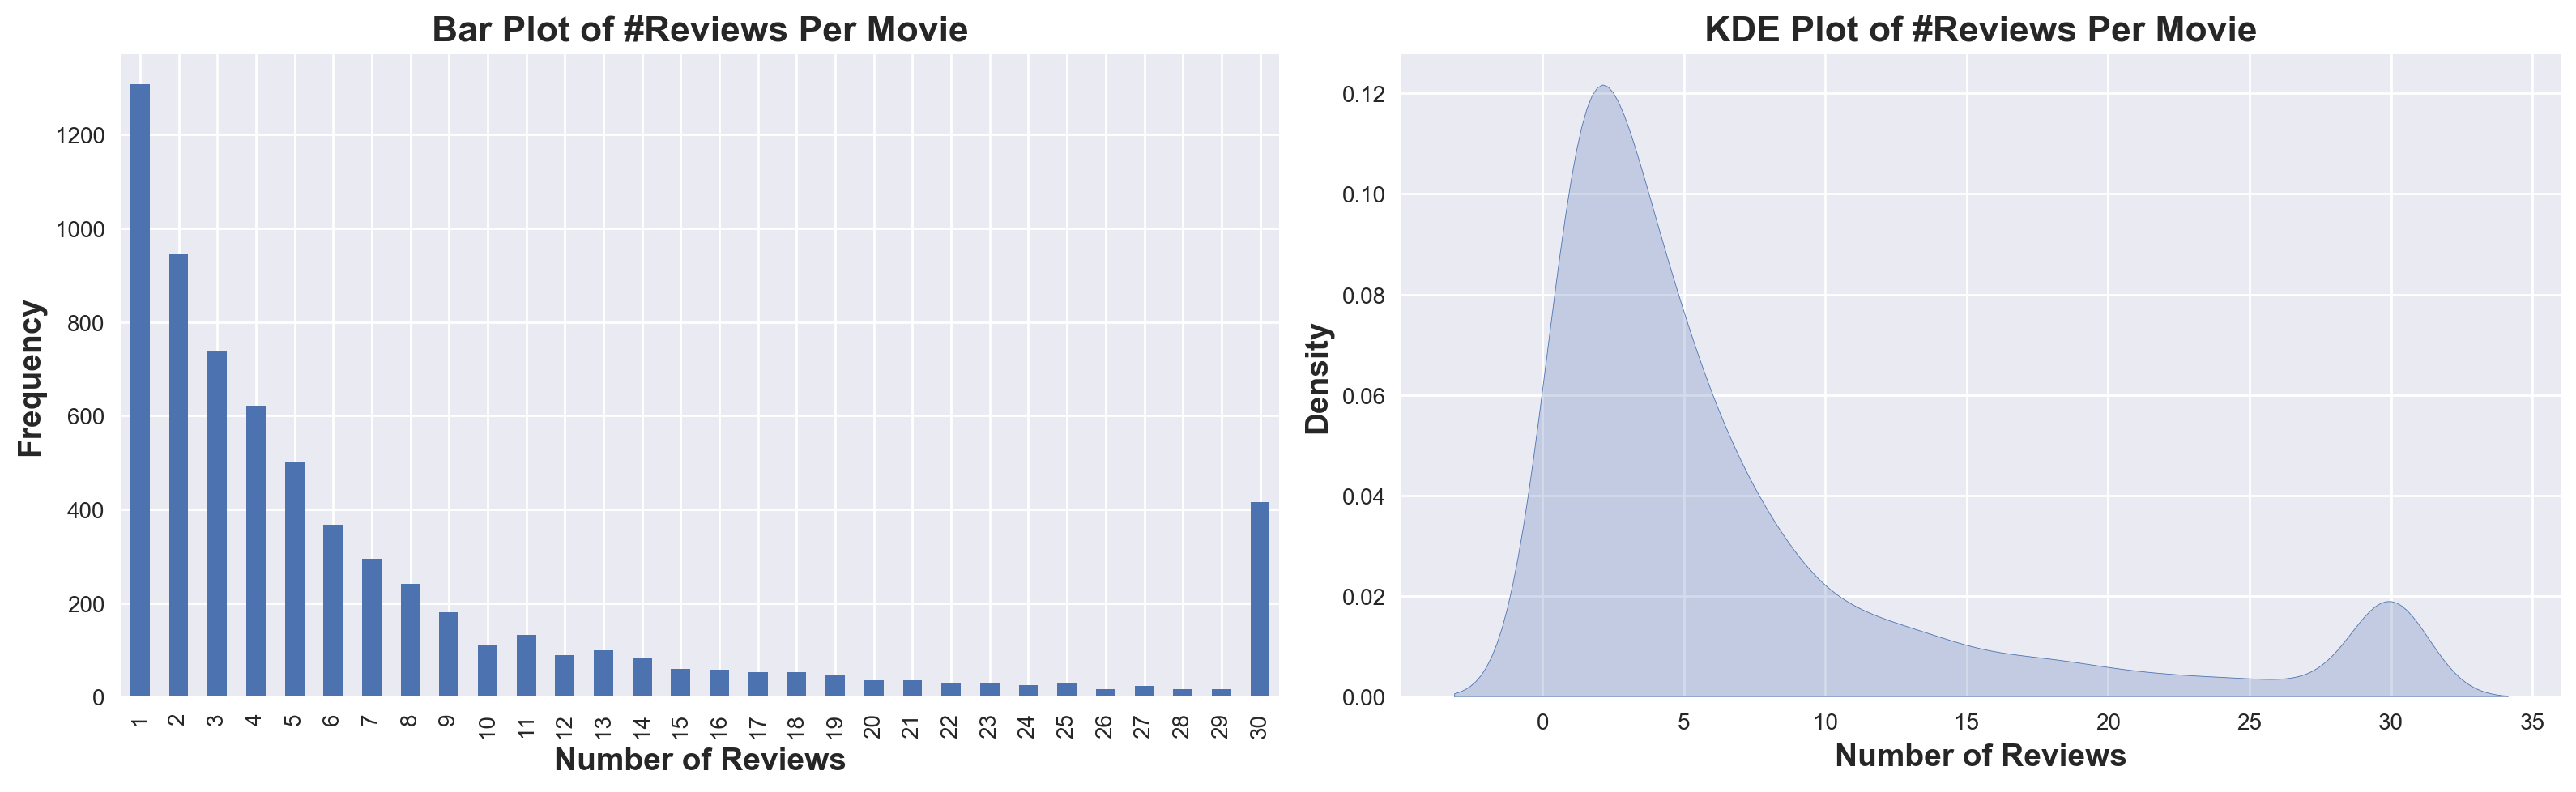

In [186]:
# Utility function to clean data by replacing inf with NaN and dropping NaN values
def clean_data(dft):
    dft.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values
    return dft.dropna()  # Drop NaN values
    
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# First subplot
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft = clean_data(dft)  # Clean before plotting

dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')

# Second subplot
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
dft = clean_data(dft)  # Clean before plotting
sns.kdeplot(dft, ax=ax, fill=True) 
ax.set_title('KDE Plot of #Reviews Per Movie', fontsize=16, fontweight='bold') 
ax.set_xlabel('Number of Reviews', fontsize=14, fontweight='bold') 
ax.set_ylabel('Density', fontsize=14, fontweight='bold') 

fig.tight_layout()
plt.show()

Most movies received only 1 review. As the number of reviews increases, the frequency of how many of that amount of reviews decreases, with the exception of 30 reviews. Theres is only a minimal amount of movies that received over 20 reviews, then suddenly, there are over 400 movies that received 30 reviews.

- <H3>Let's check the distribution of test and train dataset.</H3>

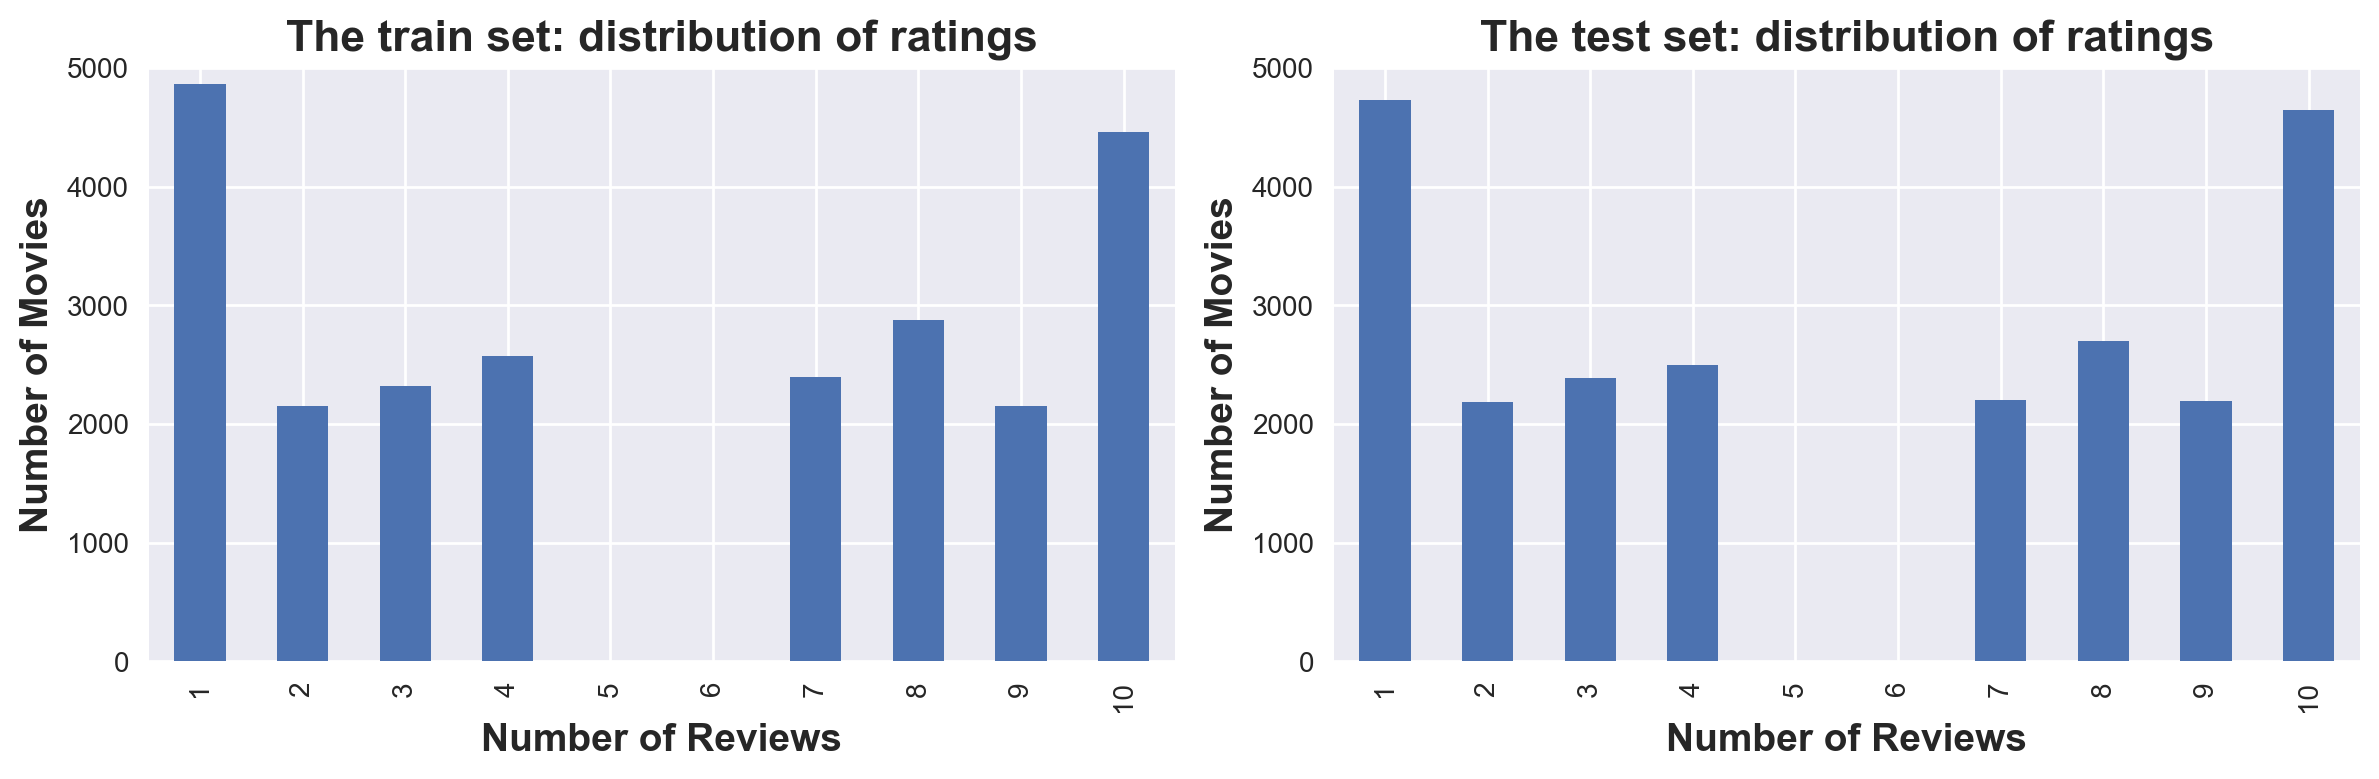

In [190]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# First subplot
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)

ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontsize=14, fontweight='bold')

# Second subplot
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)

ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontsize=14, fontweight='bold')

fig.tight_layout()

This graph is only showing number of reviews from 1-10. Of this range, the majority of movies have either 1 review, or 10 reviews. There are no movies with 5, nor with 6 reviews. Train and test set distributions, look the same. There is not imbalance.

- <H3>Distribution of negative and positive reviews over the years for two parts of the dataset.</H3>

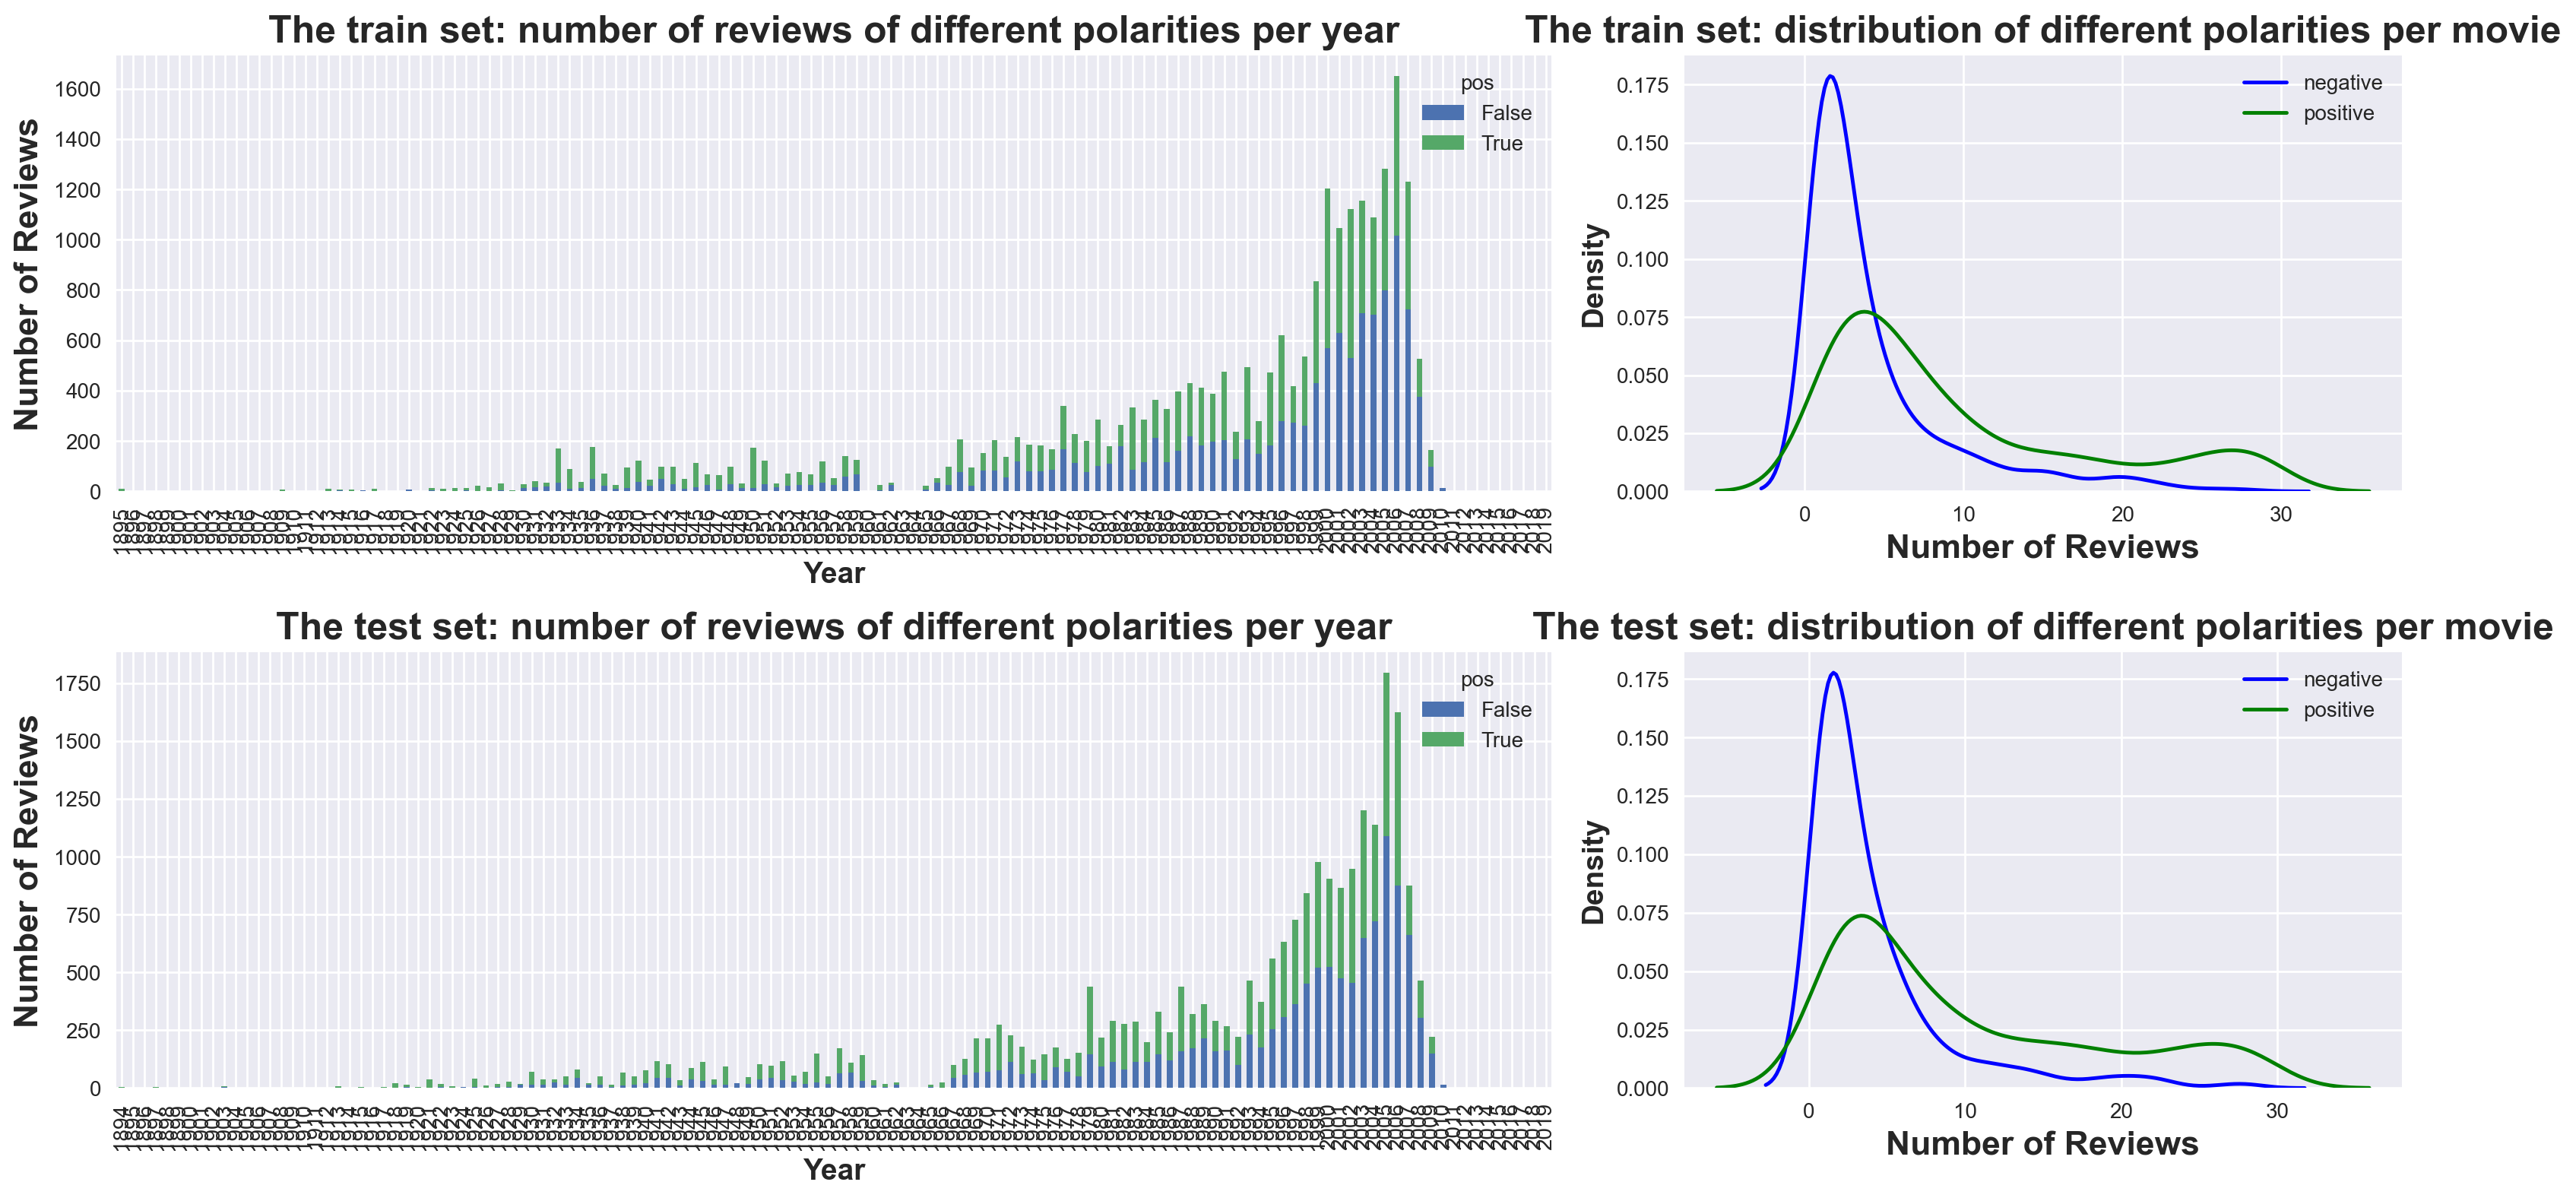

In [194]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))
# Define a utility function to handle inf values

def clean_data(dft):
    dft.replace([np.inf, -np.inf], np.nan, inplace=True)  # Ensure inf values are replaced
    return dft.dropna()  # Drop rows with NaN values
    
# Suppress chained assignment warnings
pd.options.mode.chained_assignment = None

# First subplot: Train set review counts by year
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft = clean_data(dft)  # Clean data before plotting
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year', fontsize=18, fontweight='bold')
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Reviews', fontsize=16, fontweight='bold')

# Second subplot: Train set distribution of reviews
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
dft = clean_data(dft)  # Clean data before plotting
if (False in dft.columns) and (True in dft.columns):
    sns.kdeplot(dft[False], color='blue', label='negative', ax=ax)
    sns.kdeplot(dft[True], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie', fontsize=18, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontsize=16, fontweight='bold') 
ax.set_ylabel('Density', fontsize=14, fontweight='bold')

# Third subplot: Test set review counts by year
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft = clean_data(dft)  # Clean data before plotting
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year', fontsize=18, fontweight='bold')
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Reviews', fontsize=16, fontweight='bold')

# Fourth subplot: Test set distribution of reviews
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
dft = clean_data(dft)  # Clean data before plotting
if (False in dft.columns) and (True in dft.columns):
    sns.kdeplot(dft[False], color='blue', label='negative', ax=ax)
    sns.kdeplot(dft[True], color='green', label='positive', ax=ax)
    
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie', fontsize=18, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontsize=16, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')

plt.subplots_adjust(hspace=0.6) 
fig.tight_layout()

The distributions for the False and True classes, in both the training and testing datasets, are fairly consistent, with the exception of a slight difference in the total number of reviews, which varies by about two. Additionally, there was a disproportionate number of movies that had exactly two negative reviews. Overall, there are more positive reviews than negative ones.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  </h2>
    
Agreed. 
    
</div>

## Evaluation Procedure

- Composing an evaluation routine which can be used for all models in this project

In [28]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>  Reviewer's comment </h2>
    

Notice that **type** veriable is green in the function above. When you see that your variables are green, you should think of another name, since green color indicates that this name is reserved in python. I know that our example on the platform included a similar code, but it is a great opportunity to point out this thing. 
</div>

## Normalization

- We assume all models below accept texts in lowercase, and without any digits, punctuations marks etc.

In [29]:
df_reviews['review_norm'] = df_reviews['review'].str.lower()

In [30]:
# Replace any one or more consecutive digit(0-9), with empty string.
df_reviews['review_norm'] = df_reviews['review_norm'].str.replace(r'\d+', '', regex=True)

# Replace anything that is not a word or a space with empty string.
df_reviews['review_norm'] = df_reviews['review_norm'].str.replace(r'[^\w\s]', '', regex=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  </h2>
    
Nice code!     
</div>
<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  </h2>
    
String methods can be applied one after another. 

</div>

In [31]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tconst           47331 non-null  object  
 1   title_type       47331 non-null  category
 2   primary_title    47331 non-null  object  
 3   original_title   47331 non-null  object  
 4   start_year       47331 non-null  int64   
 5   end_year         47331 non-null  object  
 6   runtime_minutes  47331 non-null  object  
 7   is_adult         47331 non-null  int64   
 8   genres           47331 non-null  object  
 9   average_rating   47331 non-null  float64 
 10  votes            47331 non-null  Int64   
 11  review           47331 non-null  object  
 12  rating           47331 non-null  int64   
 13  sp               47331 non-null  object  
 14  pos              47331 non-null  bool    
 15  ds_part          47331 non-null  category
 16  idx              47331 non-null  int64  

## Train / Test Split

- Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [32]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#targets
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  </h2>
    
Correct. 

</div>

## Working with models

### Model 0 - Constant

- Dummy Model

In [33]:
dummyModel = DummyClassifier()
dummyModel.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier()

- Call function to evaluate model

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


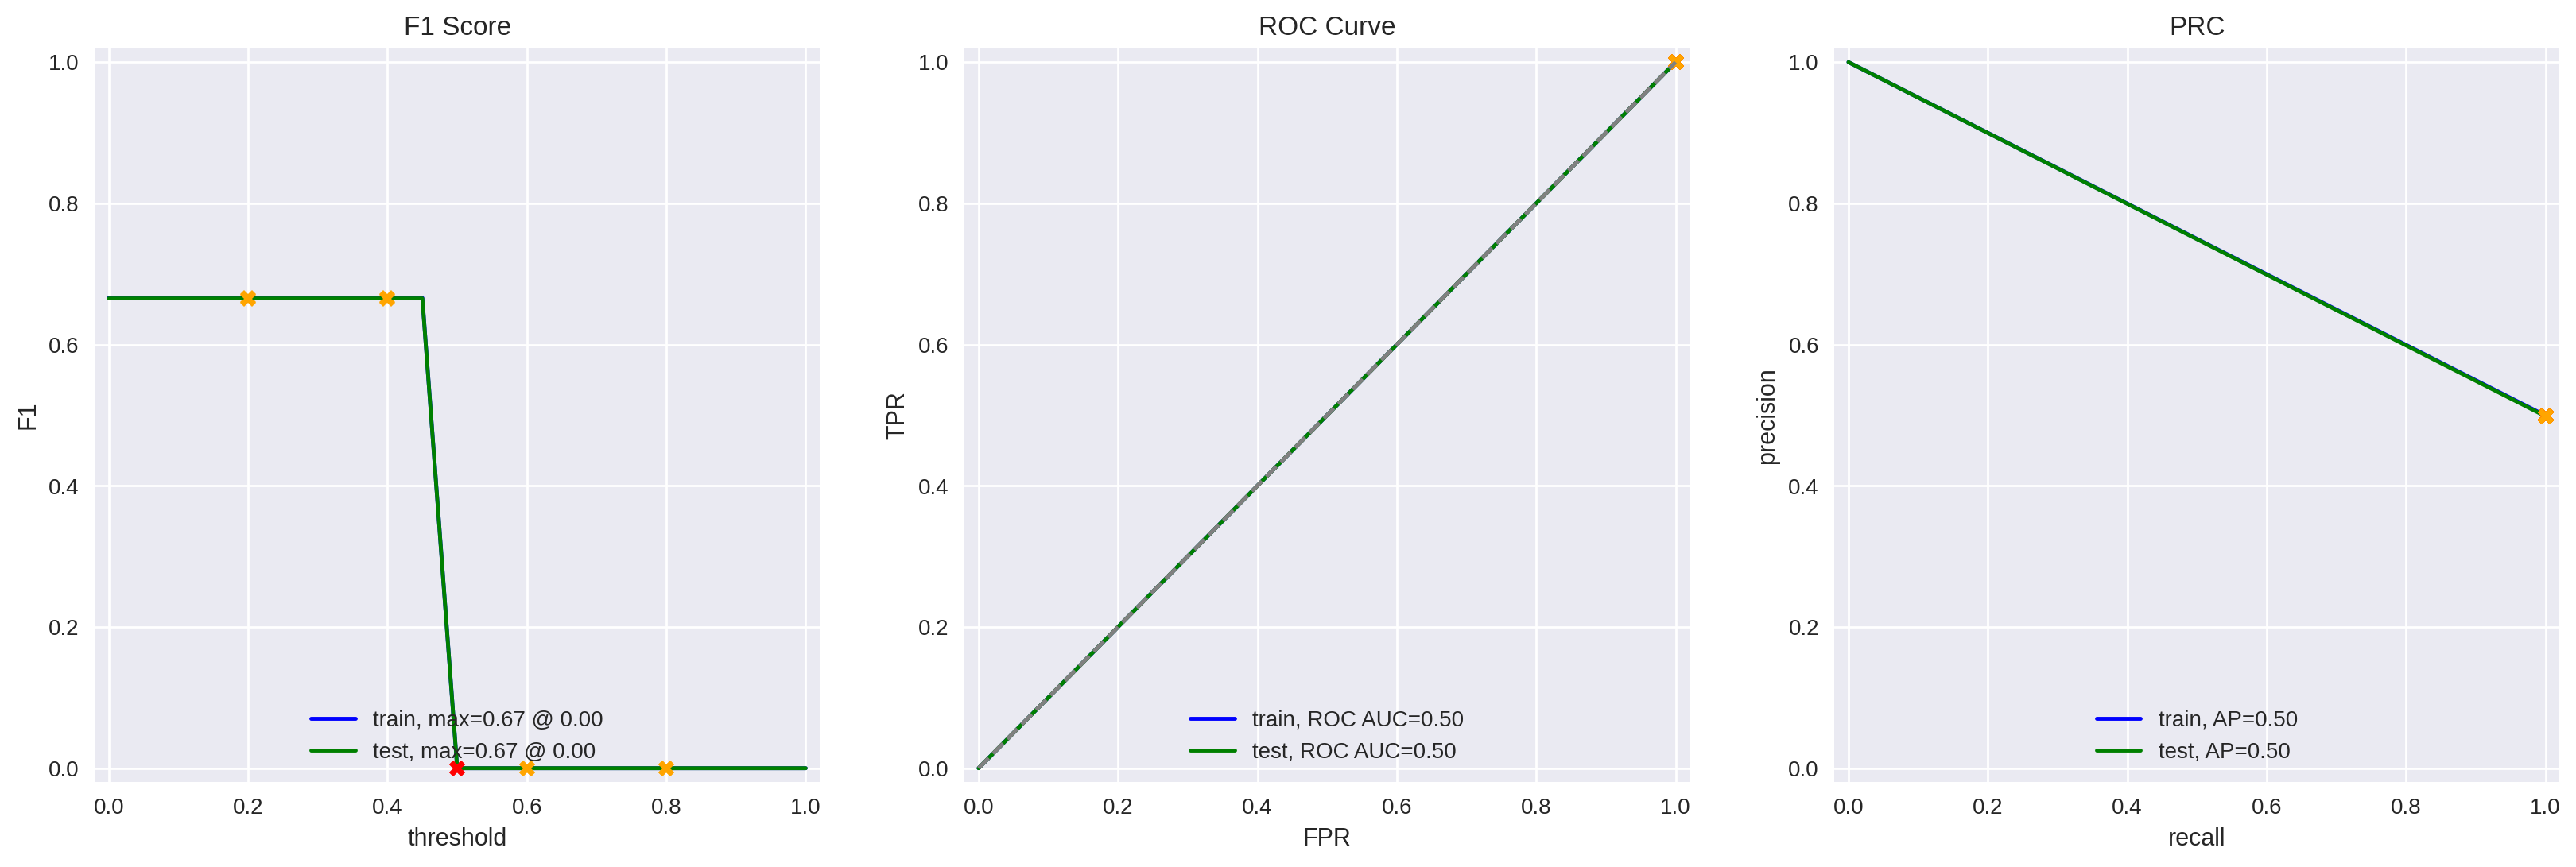

In [34]:
evaluate_model(dummyModel, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

<b>Accuracy</b>
- The model performed no better than random guessing on both datasets

<b>F1 score</b>
- F1 Score: The F1 score is 0.0 for both train and test. This score is a balance between precision and recall, and a score of 0 indicates that the model didn't successfully identify any positive classes. When the model doesn't predict any positive instances correctly, the F1 score drops to zero.
    
<b>ROC</b>
- The ROC AUC score is also 0.5, meaning no discrimination between positive and negative classes, along the same lines as random guessing.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  </h2>
    
Correct. 

</div>

### Model 1 - NLTK, TF-IDF and LR

- NLTK (stop words)

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
stop_words = set(stopwords.words('english'))

- TF-IDF (using NLTK stop words)

In [37]:
#Create a TF-IDF Vectorizer
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

In [38]:
#Fit and transform the training data, and transform the test data
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

- LR

In [39]:
#Instantiate and Fit the LR Model
lr_model_1 = LogisticRegression()
lr_model_1.fit(train_features_1, train_target)

LogisticRegression()

- Call function to evaluate model

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


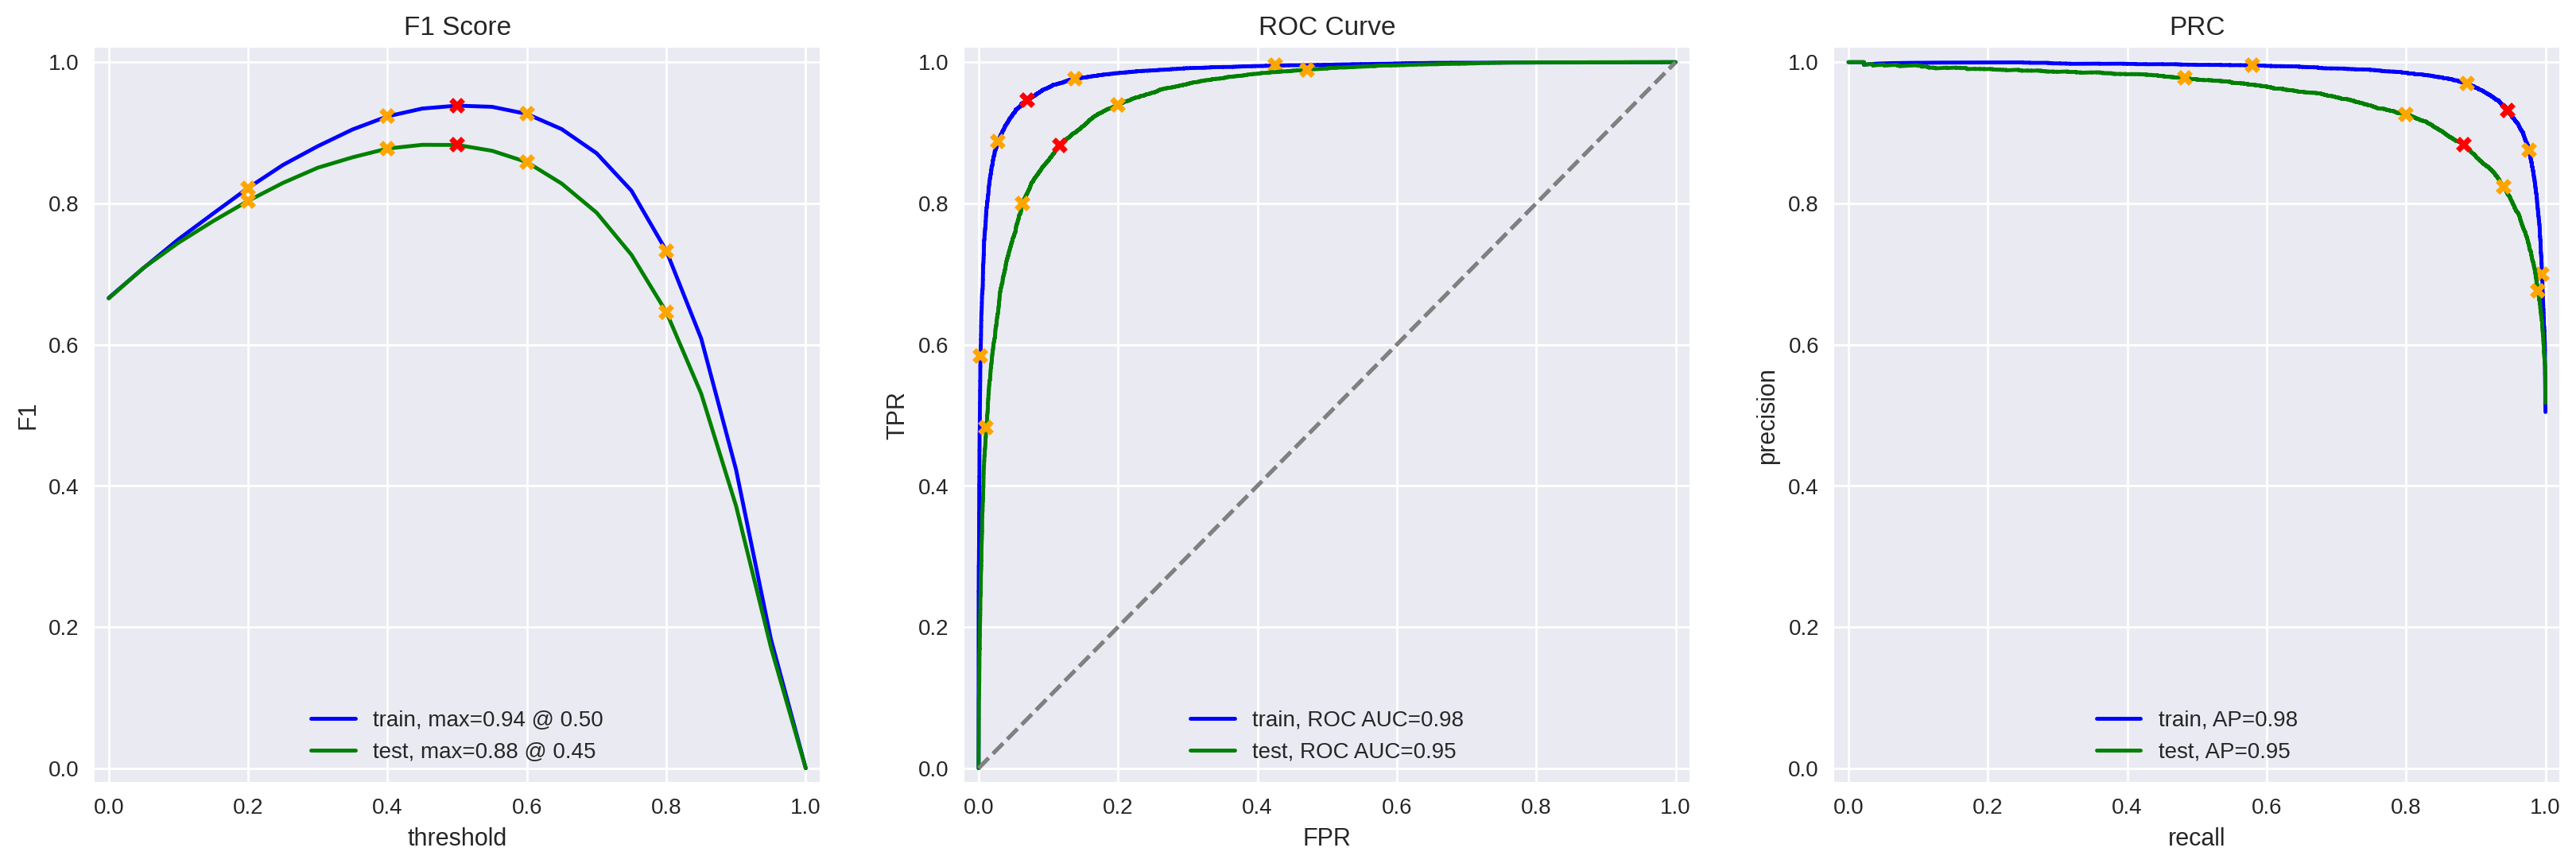

In [40]:
evaluate_model(lr_model_1, train_features_1, train_target, test_features_1, test_target)

The Logistic Regression model achieved strong performance on both the training and testing datasets. The accuracy and F1 scores for both datasets were high, at 0.94 for training and 0.88 for testing. The Average Precision Score (APS) was also impressive, with scores of 0.98 for training and 0.95 for testing. Additionally, the ROC AUC values were notably high, at 0.98 for training and 0.95 for testing, indicating excellent predictive capability. Overall, the model demonstrates effective classification performance with only a slight drop in test accuracy compared to training.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment </h2>
    
Correct. The model exceeds the F1 threshold and has good precision. 
    
</div>

### Model 3 - spaCy, TF-IDF and LR

- spaCy

In [41]:
# for processing text for tokenization and part-of-speech tagging
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [42]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

- TF-IDF model using spaCy

In [43]:
df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [44]:
#Create a TF-IDF Vectorizer
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

In [45]:
#Fit and transform the training data, and transform the test data
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_lemma'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_lemma'])

- LR

In [46]:
#Instantiate and Fit the LR Model
lr_model_3 = LogisticRegression()
lr_model_3.fit(train_features_3, train_target)

LogisticRegression()

- Call the function to evaluate the model

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


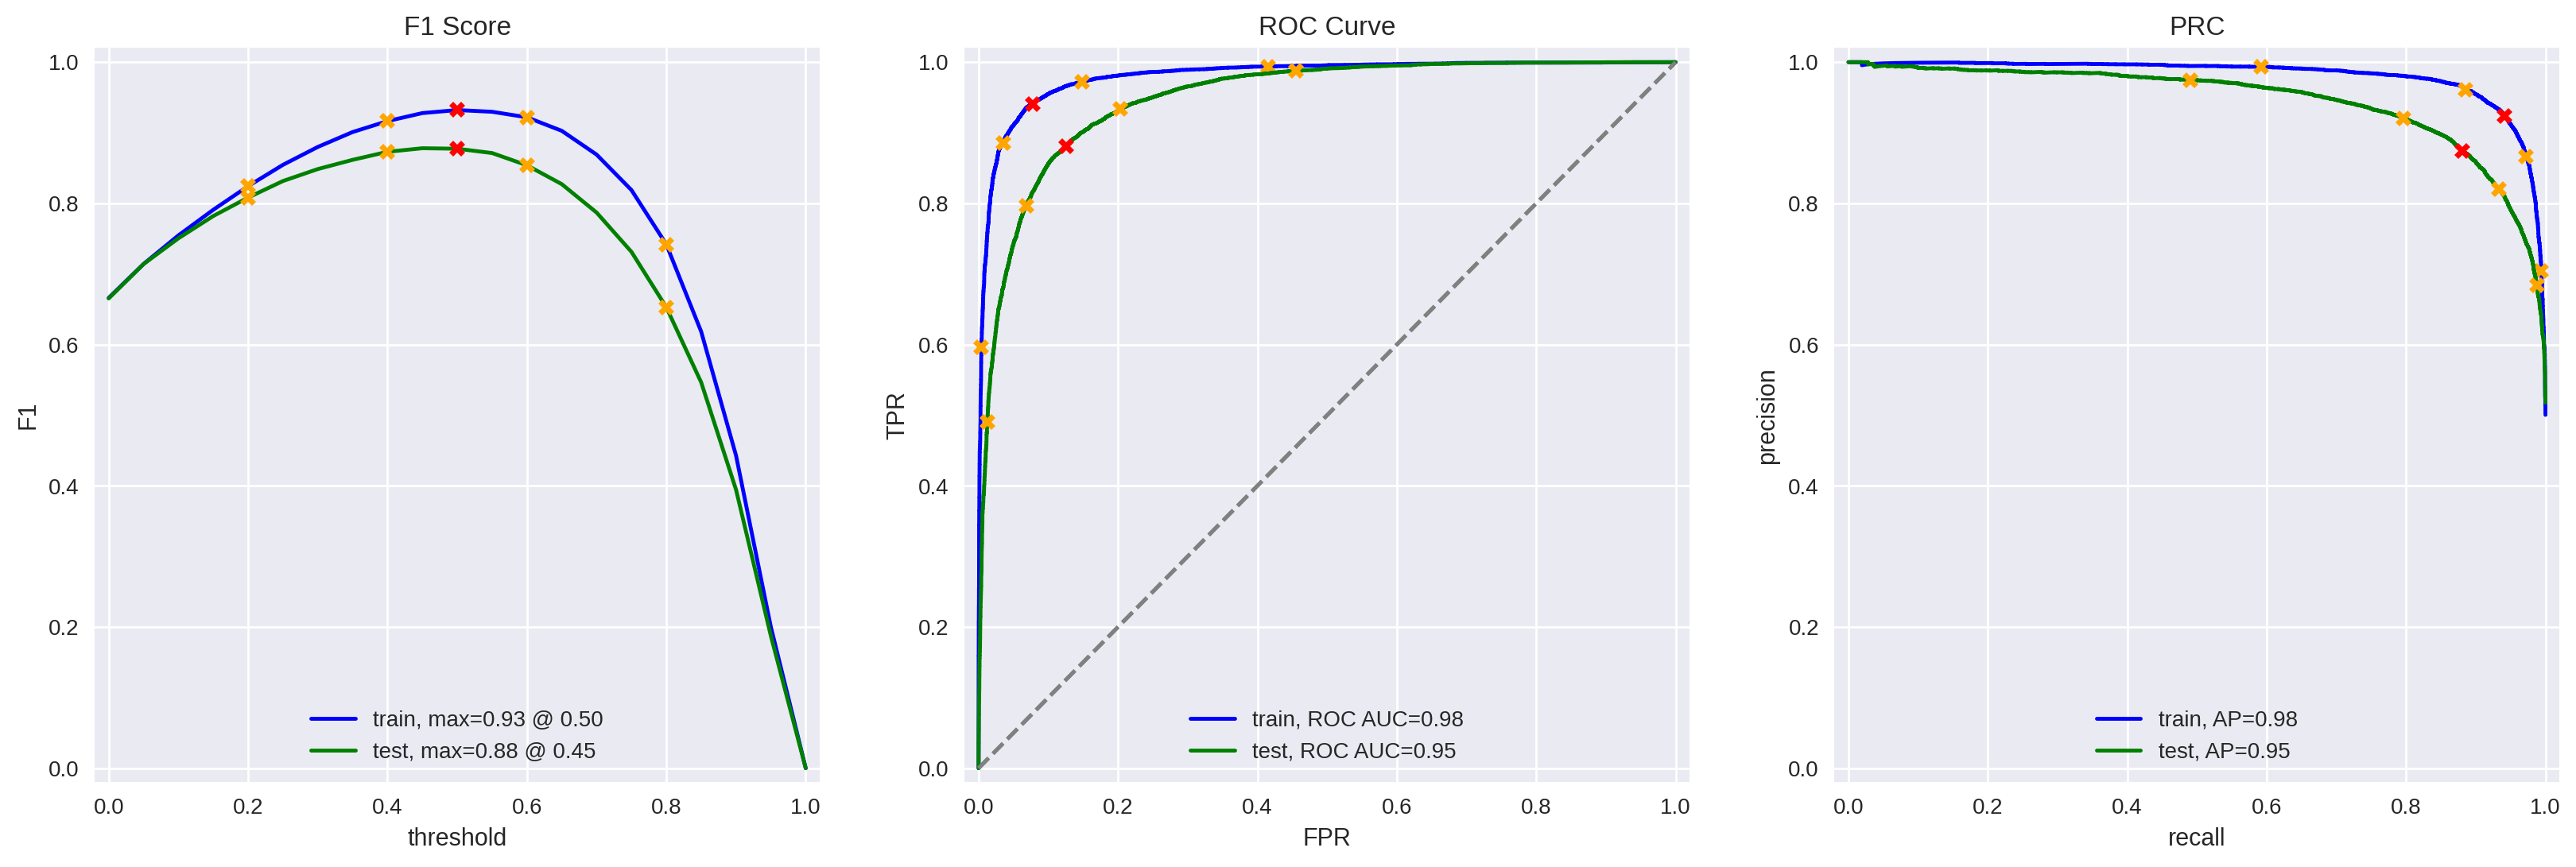

In [47]:
evaluate_model(lr_model_3, train_features_3, train_target, test_features_3, test_target)

The Logistic Regression model, after utilizing lemmatization in the text preprocessing phase, demonstrated robust performance on both the training and testing datasets. The accuracy and F1 scores remained high, at 0.93 for training and 0.88 for testing, which are consistent with the previous results, indicating a slight improvement in training accuracy from 0.94 to 0.93 but steady test performance. The Average Precision Score (APS) and ROC AUC values continued to show excellent predictive capability, with scores of 0.98 for training and 0.95 for testing, similar to the previous performance metrics. Overall, the lemmatization did not significantly impact the performance, maintaining high accuracy and F1 scores while preserving effective classification capabilities.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment </h2>
    
We see quite similar performance. 
    
</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier



- Light GBM

In [48]:
#Instantiate and Fit the LGBMClassifier Model
LGBM_model_4 = LGBMClassifier()

- fit TF-IDF with spaCy

In [49]:
LGBM_model_4.fit(train_features_3, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


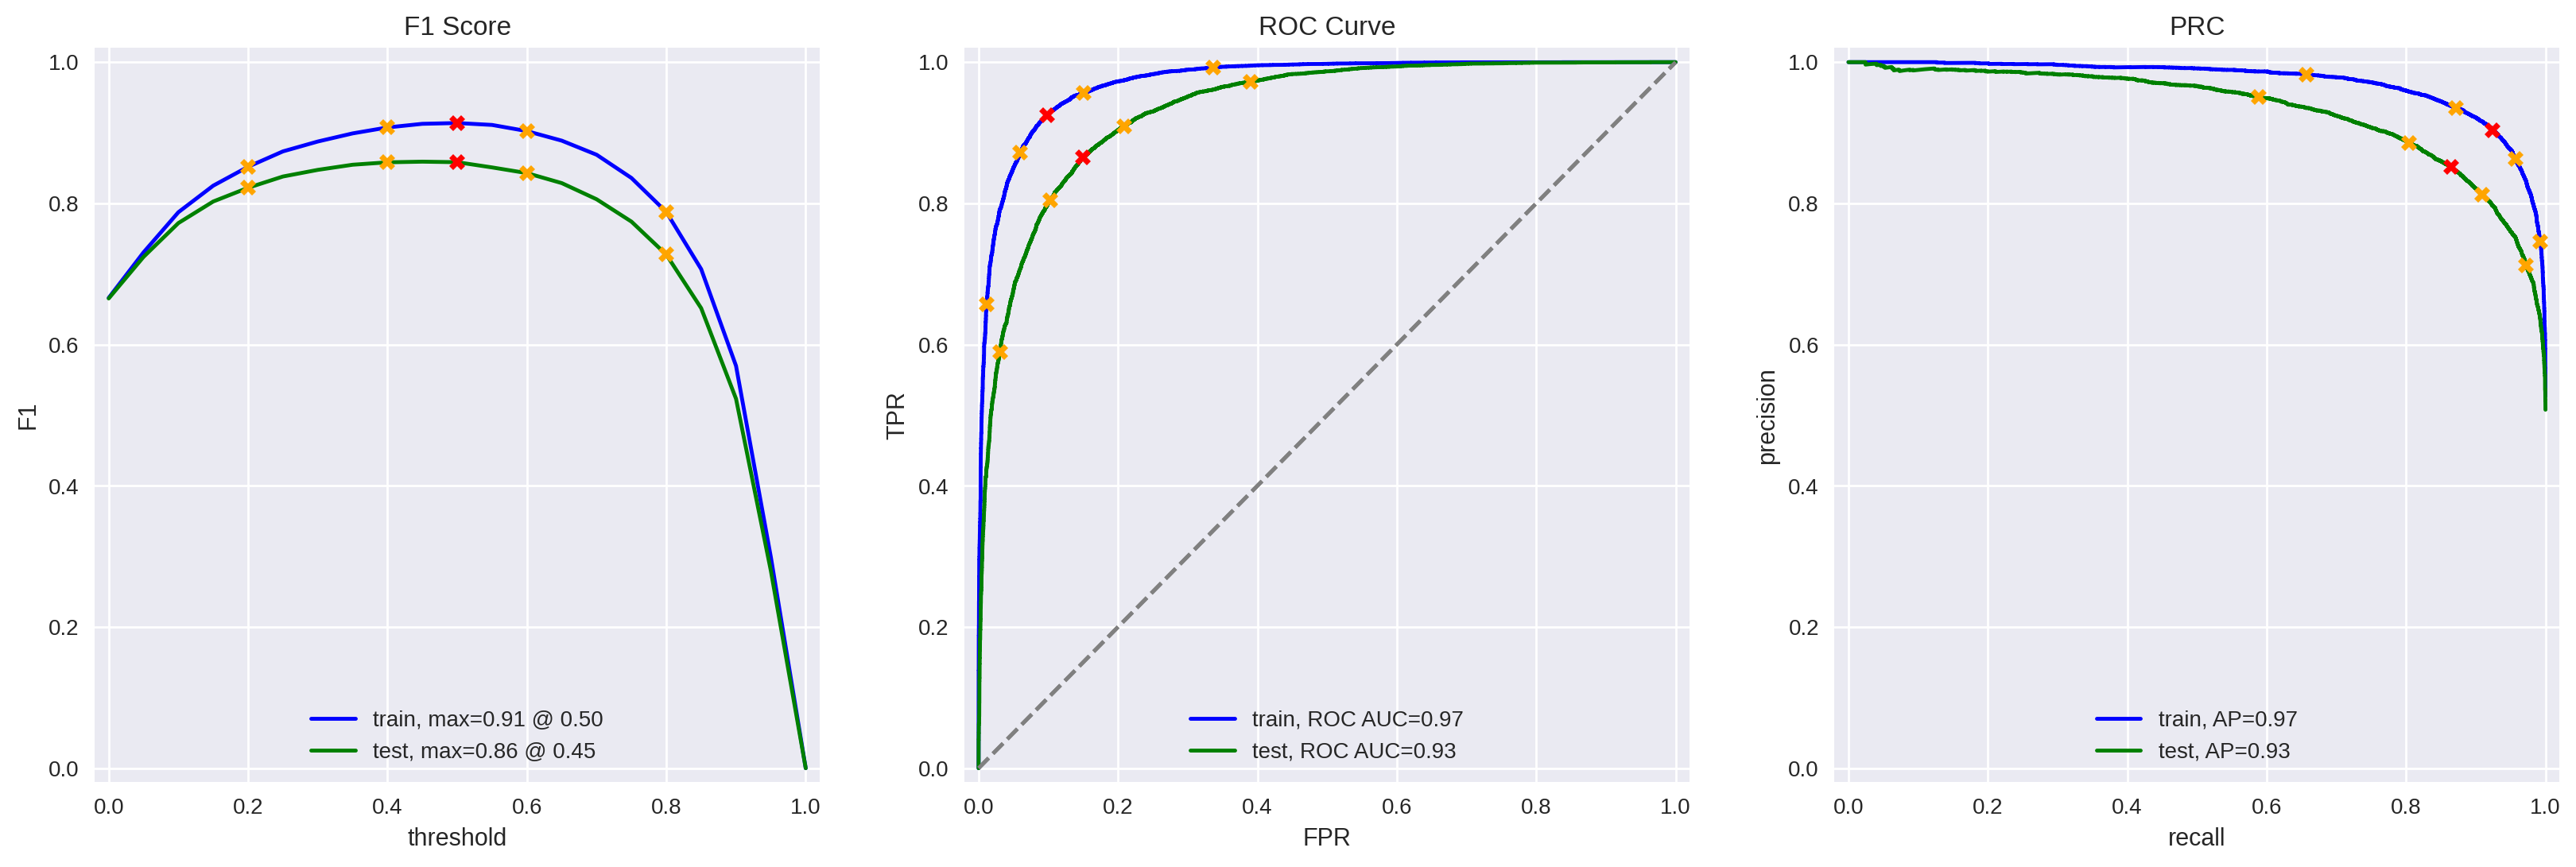

In [50]:
evaluate_model(LGBM_model_4, train_features_3, train_target, test_features_3, test_target)

The LightGBM model demonstrated a decrease in both training and testing accuracy (0.91 and 0.86, respectively) compared to the previous models, where both were at 0.93 and 0.88. The F1 score also shows a reduction, demonstrating LightGBM's lower performance compared to Logistic Regression and the intermediate model.
Average Precision Score and ROC AUC values also decreased for LightGBM (APS: 0.97 train, 0.93 test; ROC AUC: 0.97 train, 0.93 test), indicating it has a weaker ability to classify positive instances compared to the previous models.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment </h2>
    
Good. 
    
</div>


###  Adding my own reviews.

In [51]:
my_reviews = pd.DataFrame([
    'The movie was boring. I did not enjoy watching it at all.',
    'I actually fell asleep in the middle of the movie. It was so boring',
    'I absolutely loved everything about this movie.',    
    'The acting was horrible. The script was confusing. The sound effects were scary. I hated this movie. I want my money back.',
    'I didn\'t expect this movie to be so good! It was my favorite movie of the year.',
    'The movie started out slow, but then it got good. I can\'t believe how much fun I had watching it.',
    'What a rotten attempt at a comedy. Not a single joke was funny. I won\'t be watching this movie again!',
    'Hated it. Really hated it.',
    'Everyone loved this movie. It was so fun from start to finish.',
    'I was confused. Was this a comeday, action, or drama? The plot twisted too much, and it was just a plethora of confusion.'
], columns=['review'])

In [52]:
my_reviews['review_norm'] = my_reviews['review'].str.lower()

In [53]:
# Replace any one or more consecutive digit(0-9), with empty string.
my_reviews['review_norm'] = my_reviews['review_norm'].str.replace(r'\d+', '', regex=True)

# Replace anything that is not a word or a space with empty string.
my_reviews['review_norm'] = my_reviews['review_norm'].str.replace(r'[^\w\s]', '', regex=True)

In [54]:
# Apply text preprocessing on custom reviews. Lemmatization.
my_reviews['review_lemma'] = my_reviews['review_norm'].apply(text_preprocessing_3)

In [55]:
print(my_reviews['review_lemma'])

0    the movie be boring I do not enjoy watch it at...
1    I actually fall asleep in the middle of the mo...
2        I absolutely love everything about this movie
3    the acting be horrible the script be confuse t...
4    I do not expect this movie to be so good it be...
5    the movie start out slow but then it get good ...
6    what a rotten attempt at a comedy not a single...
7                               hate it really hate it
8    everyone love this movie it be so fun from sta...
9    I be confused be this a comeday action or dram...
Name: review_lemma, dtype: object


- TF-IDF

In [56]:
# Transform custom reviews using the trained TF-IDF vectorizer
my_features_3 = tfidf_vectorizer_3.transform(my_reviews['review_lemma'])

In [57]:
# Predict sentiment using the trained logistic regression model (or LGBM model if preferred)
predictions = lr_model_3.predict(my_features_3)

In [58]:
# Display the predictions
print(predictions)

[False False  True False  True  True False False  True False]


The model predicted all of my reviews correctly, with negative reviews being marked as False, and positive reviews being marked as True.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment </h2>
    
Very good!     
</div>


### Linear Regression Model on my_reviews

In [59]:
texts = my_reviews['review_norm']

my_reviews_pred_prob3 = lr_model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob3[i]:.2f}:  {review}')

0.18:  the movie was boring i did not enjoy watching it at all
0.02:  i actually fell asleep in the middle of the movie it was so boring
0.89:  i absolutely loved everything about this movie
0.01:  the acting was horrible the script was confusing the sound effects were scary i hated this movie i w
0.99:  i didnt expect this movie to be so good it was my favorite movie of the year
0.57:  the movie started out slow but then it got good i cant believe how much fun i had watching it
0.10:  what a rotten attempt at a comedy not a single joke was funny i wont be watching this movie again
0.38:  hated it really hated it
0.97:  everyone loved this movie it was so fun from start to finish
0.40:  i was confused was this a comeday action or drama the plot twisted too much and it was just a pletho


The first column is the percentage of probability of a review being positive. (0.18 means 18\% probabilty)The only review that the model did not predict accurately was the 5th review, which was positive, but it was only given 57\% probability rate.

### LGBM Model on my_reviews

In [60]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = LGBM_model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.28:  the movie was boring i did not enjoy watching it at all
0.13:  i actually fell asleep in the middle of the movie it was so boring
0.84:  i absolutely loved everything about this movie
0.07:  the acting was horrible the script was confusing the sound effects were scary i hated this movie i w
0.92:  i didnt expect this movie to be so good it was my favorite movie of the year
0.80:  the movie started out slow but then it got good i cant believe how much fun i had watching it
0.46:  what a rotten attempt at a comedy not a single joke was funny i wont be watching this movie again
0.62:  hated it really hated it
0.89:  everyone loved this movie it was so fun from start to finish
0.52:  i was confused was this a comeday action or drama the plot twisted too much and it was just a pletho


The LGBM model was not as accurate as the Linear Regression model, but still did very good. It is interesting, that on the 8th review, which uses the word "hate", that the LGBM model marked this as a 64\% chance of being positive.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment </h2>
    
Nice results!     
</div>


### Random Forest Model on my_reviews

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

# Apply vectorization on the lemmatized reviews
features = tfidf_vectorizer_3.fit_transform(my_reviews['review_lemma'])
my_reviews['label'] = [0, 0, 1, 0, 1, 1, 0, 0, 1, 0] 

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation and predict probabilities
predicted_probs = cross_val_predict(
    rf_model,
    features,
    my_reviews['label'],
    cv=5,
    method='predict_proba'
)[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{predicted_probs[i]:.2f}:  {review}')

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.64:  the movie was boring i did not enjoy watching it at all
0.59:  i actually fell asleep in the middle of the movie it was so boring
0.25:  i absolutely loved everything about this movie
0.13:  the acting was horrible the script was confusing the sound effects were scary i hated this movie i w
0.34:  i didnt expect this movie to be so good it was my favorite movie of the year
0.42:  the movie started out slow but then it got good i cant believe how much fun i had watching it
0.24:  what a rotten attempt at a comedy not a single joke was funny i wont be watching this movie again
0.25:  hated it really hated it
0.49:  everyone loved this movie it was so fun from start to finish
0.24:  i was confused was this a comeday action or drama the plot twisted too much and it was just a pletho


This random forest only predicted correctly 30\% of the time.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment </h2>
    
It's great that you try different models!     
</div>


## Conclusions

The primary objective of this project was to develop a sentiment analysis model for classifying movie reviews as either positive or negative. To achieve this, I employed various preprocessing techniques, including normalization, tokenization, and lemmatization, followed by feature extraction using TF-IDF vectorization. I then trained and evaluated models, such as Logistic Regression and LGBMClassifier to assess their performance.

The models demonstrated strong predictive capability, with the Logistic Regression model trained on lemmatized reviews providing particularly reliable results. This project also highlighted the importance of text preprocessing in enhancing model accuracy and the effectiveness of transformer-based embeddings for capturing nuanced semantic information. In conclusion, this project successfully developed a capable sentiment analysis system.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment </h2>
    
Excellent, thank you so much! 

</div>


# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions